In [1]:
import pandas as pd

drug_df = pd.read_csv("Data/drug200.csv")
drug_df = drug_df.sample(frac=1)
drug_df.head(3)


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
141,64,F,LOW,NORMAL,25.741,DrugY
112,35,M,LOW,NORMAL,9.170,drugX
186,70,M,HIGH,HIGH,9.849,drugB


In [3]:
from sklearn.model_selection import train_test_split

X = drug_df.drop("Drug", axis=1)
y = drug_df.Drug

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125
)


In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

cat_col = X.select_dtypes(include=["object", "bool"]).columns.tolist()
num_col = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

transform = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(), cat_col),
        ("num_imputer", SimpleImputer(strategy="median"), num_col),
        ("num_scaler", StandardScaler(), num_col),
    ]
)
pipe = Pipeline(
    steps=[
        ("preprocessing", transform),
        ("model", RandomForestClassifier(n_estimators=100, random_state=125)),
    ]
)
pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoder', OrdinalEncoder(),
                                                  ['Sex', 'BP', 'Cholesterol']),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'Na_to_K']),
                                                 ('num_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'Na_to_K'])])),
                ('model', RandomForestClassifier(random_state=125))])

In [25]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

print("Accuracy: ", str(round(accuracy, 2) * 100) + "%", "F1: ", round(f1, 2))


Accuracy:  97.0% F1:  0.94


In [20]:
# Write metrics to file
with open("Results/metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {accuracy.round(2)}, F1 Score = {f1.round(2)}.")


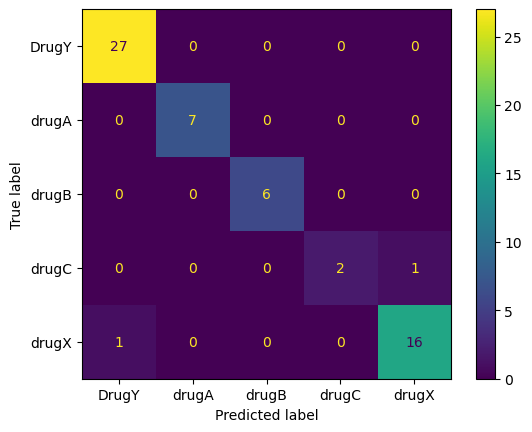

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

predictions = pipe.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("Results/model_results.png", dpi=120)


In [22]:
import skops.io as sio

sio.dump(pipe, "Model/drug_pipeline.skops")


In [23]:
sio.load("Model/drug_pipeline.skops", trusted=True)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoder', OrdinalEncoder(),
                                                  ['Sex', 'BP', 'Cholesterol']),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'Na_to_K']),
                                                 ('num_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'Na_to_K'])])),
                ('model', RandomForestClassifier(random_state=125))])

![confusion matrix](.\Results\model_results.png)